# Proyecto Ising

In [1]:
#Bibliotecas útiles
import numpy as np
import matplotlib.pyplot as plt
import time

## Clase Hamiltoniano

In [2]:
class Hamiltoniano:
  def __init__(self, J, g, N):
    self.J = J
    self.g = g
    self.N = N

  def pauliX(self):
    return np.array([[0,1],[1,0]])

  def pauliZ(self):
      return np.array([[1,0],[0,-1]])

  def identidad(self):
      return np.array([[1,0],[0,1]])

    #funcion para calcular producto tensorial
  def productoTensorial(self, matrizA, matrizB):
    m = len(matrizA)
    n = len(matrizA[0])
    p = len(matrizB)
    q = len(matrizB[0])

    result = np.zeros((m * p, n * q))

    for i in range(m):
        for j in range(n):
            for k in range(p):
                for l in range(q):
                    result[i * p + k][j * q + l] = matrizA[i][j] * matrizB[k][l]

    return result

    #ordenar productos tensoriales para x
  def ordenadorX(self, i):
    result = self.identidad()

    for k in range(1, self.N + 1):
        if k == 1:
            if k == i:
                result = self.pauliX()
            else:
                result = self.identidad()
        else:
            if k == i:
                result = self.productoTensorial(result, self.pauliX())
            else:
                result = self.productoTensorial(result, self.identidad())
    return result

    #ordenar productos tensoriales para z
  def ordenadorZ(self, i):
    result = self.identidad()

    for k in range(1, self.N + 1):
        if k == 1:
            if k == i:
                result = self.pauliZ()
            else:
                result = self.identidad()
        elif k == i:
            result = self.productoTensorial(result, self.pauliZ())
        elif k == i+1:
            result = self.productoTensorial(result, self.pauliZ())
        else:
            result = self.productoTensorial(result, self.identidad())
    return result

    #construir hamiltoniano
  def construirHamiltoniano(self):
    sumZ = np.zeros((2**self.N, 2**self.N))
    for i in range(1, self.N):
        sumZ += self.ordenadorZ(i)
    sumZ *= -self.J

    sumX = np.zeros((2**self.N, 2**self.N))
    for i in range(1, self.N + 1):
        sumX += self.ordenadorX(i)
    sumX *= -self.g

    return sumZ + sumX

In [3]:
#imprimir hamiltoniano (solo para verificar y valores pequños)
t1 = time.time()
Ham = Hamiltoniano(1, 1, 10)
H = Ham.construirHamiltoniano()
t2 = time.time()

print(H)
print(t2-t1)

[[-9. -1. -1. ... -0. -0. -0.]
 [-1. -7. -0. ... -0. -0. -0.]
 [-1. -0. -5. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -5. -0. -1.]
 [-0. -0. -0. ... -0. -7. -1.]
 [-0. -0. -0. ... -1. -1. -9.]]
34.90878176689148


## Solución de la dinámica

In [4]:
#definir variables
tList = np.linspace(0, 10, 1000)
h = tList[1]-tList[0]

In [5]:
#inicializar vector inicial
def vectorPsiInit(N):
    vec = np.zeros(2**N)
    vec[0] = 1
    return vec

### Implementación RK4

In [6]:
#derivada de la funcion
def derivadaVectorPsi(state, oper):
    return -1.0j * np.matmul(oper, state)

In [48]:
#se define funcion rk4
def rk4(func, oper, state, h):
    k_1 = h*func(oper,state)
    k_2 = h*func(oper,state+((k_1)/2))
    k_3 = h*func(oper,state+((k_2)/2))
    k_4 = h*func(oper,state+k_3)
    return state + (k_1 + 2*k_2 + 2*k_3 + k_4)*(1/6)

In [49]:
#se implementa el resultado
tiempo_1 = time.time()

vectorPsiRK4 = np.zeros(tList.size)
vecRK4 = vectorPsiInit(10)

for i in range(tList.size):
    vectorPsiRK4[i] = vecRK4[0].real
    vectorPsiN = rk4(derivadaVectorPsi, H, vecRK4, h)
    vecRK4 = vectorPsiN

tiempo_2 = time.time()
print('Duración: ', tiempo_2 - tiempo_1)

Duración:  30.26484775543213


<function matplotlib.pyplot.show(close=None, block=None)>

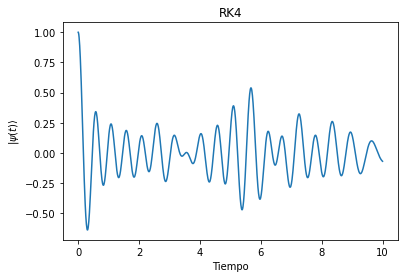

In [65]:
plt.plot(tList, vectorPsiRK4)
plt.title('RK4')
plt.xlabel('Tiempo')
plt.ylabel(r'$|\psi(t) \rangle$')

plt.show

### Solución Directa (Diagonalización)

In [22]:
def diagonalizacion(t, t_0, vec, eigVals, eigVecs):
    # base diagonal
    eigVals = -1.0j * eigVals * (t - t_0)
    expVals = np.exp(eigVals)
    expD = np.diag(expVals)
    
    psi_d = np.dot(eigVecs.T, vec)
    psi_t_d = np.dot(expD, psi_d)
    
    #base original
    psi_t = np.dot(eigVecs, psi_t_d)
    
    return psi_t

In [23]:
#implementación de la solución directa por diagonalización
tiempo_3 = time.time()


vectorPsiDiag = np.zeros(tList.size)
vecDiag = vectorPsiInit(10)
vecDiagCopy = vecDiag.copy()

autoVal, autoVec = np.linalg.eigh(H)
autoVecInv = np.linalg.inv(autoVec)

for i in range(tList.size):
    vectorPsiDiag[i] = vecDiag[0].real
    vectorPsiN = diagonalizacion(tList[i], tList[0], vecDiagCopy, autoVal, autoVec)
    vecDiag = vectorPsiN
    
tiempo_4 = time.time()

print('Duración: ', tiempo_4 - tiempo_3)

Duración:  13.441778182983398


<function matplotlib.pyplot.show(close=None, block=None)>

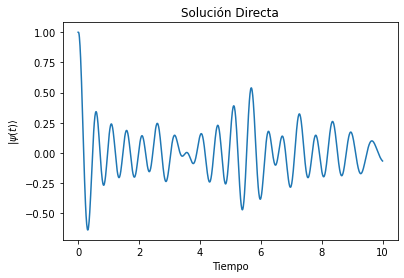

In [24]:
plt.plot(tList, vectorPsiDiag)
plt.title('Solución Directa')
plt.xlabel('Tiempo')
plt.ylabel(r'$|\psi(t) \rangle$')

plt.show